Se importan las siguiente librerías:
- pandas: para poder cargar el dataset
- numpy: para poder manipular los arreglos y usar vectorización
- matplotlib: para graficar
- sklarn: para poder usar el label encoding, estandarizar y obtener el MSE.

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

Se cargan los datos del dataset.

In [33]:
df = pd.read_csv('Employee.csv')
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


Función para dividir el datasaet en subconjuntos.

In [12]:
def validate(partitions: tuple[int, ...], X = np.array, Y = np.array):
  assert type(partitions) == tuple, 'Partitions must be a tuple of ints'
  assert sum(partitions) == 100, 'Sum of paritions must be 100'
  assert type(X) == np.ndarray, 'X must be a NDArray'
  assert type(Y) == np.ndarray, 'X must be a NDArray'
  assert X.shape[0] == Y.shape[0], f'X and Y must have the same dimension'

def split_sequencial (partitions: tuple[int, ...], X = np.array, Y = np.array):
  validate(partitions, X, Y)

  length = X.shape[0]
  start_index = 0
  for partition in partitions:
    step = round(partition / 100 * length)
    end_index = start_index + step
    yield X[start_index:end_index]
    yield Y[start_index:end_index]
    start_index = end_index
    start_index = end_index

Se usa label encoding en las variables `Education`, `City`, `Gender` y `EverBenched` y se obtienen todas las X como arreglos individuales para después apilarlos en una sola X la cuál estandarizaremos y particionaremos

In [17]:
X1 = LabelEncoder().fit_transform(df['Education']).astype(np.float64)
X2 = df['JoiningYear'].values.astype(np.float64)
X3 = LabelEncoder().fit_transform(df['City']).astype(np.float64)
X4 = df['Age'].values.astype(np.float64)
X5 = LabelEncoder().fit_transform(df['Gender']).astype(np.float64)
X6 = LabelEncoder().fit_transform(df['EverBenched']).astype(np.float64)
X7 = df['ExperienceInCurrentDomain'].values.astype(np.float64)
X8 = df['PaymentTier'].values.astype(np.float64)
Y = df['LeaveOrNot'].values
X = np.column_stack((X1, X2, X3, X4, X5, X6, X7, X8))
ss = StandardScaler()
X = ss.fit_transform(X)
X_train, Y_train, X_test, Y_test = split_sequencial((80, 20), X, Y)

Se define la función sigmoide.

In [10]:
def sigmoid (x):
    z = np.exp(-x)
    return 1 / (1 + z)

Se define la clase para la regresión logistica. Similar a la regresión lineal, salvo que al producto obtenido mediante multiplicar X por los coeficientes (pendiente e intersección) se le aplica la función sigmoide.

In [39]:
class LR:
  def __init__ (self, iters=100, lr=0.001):
    self.iters = iters
    self.lr = lr
    self.coefficients = None

  def fit (self, X, Y):
    X = np.column_stack([np.ones(X.shape[0]), X])
    self.coefficients = np.zeros(X.shape[1])

    for _ in range(self.iters):
      grad = self.gradient(X, Y)
      self.coefficients -= self.lr * grad

  def gradient (self, X, Y):
    m = len(Y)
    a = np.dot(X, self.coefficients)
    pred = np.vectorize(sigmoid)(a)
    #pred = np.array([sigmoid(value) for value in a])

    return np.dot(X.T, (pred-Y)) / m

  def predict (self, X):
    X = np.column_stack([np.ones(X.shape[0]), X])
    a = np.dot(X, self.coefficients)
    probabilities = np.array([sigmoid(value) for value in a])
    return np.vectorize(lambda p: 1 if p > 0.5 else 0)(probabilities)
    #return [1 if p > 0.5 else 0 for p in probabilities]

Se prueba el modelo y se muestran los coeficientes, error y los primeros 5 valores predichos respecto a los verdaderos.

In [40]:
model_lr = LR(700, 0.019)
model_lr.fit(X_train, Y_train)
Y_pred = model_lr.predict(X_test)
print(f'Coefficients: {model_lr.coefficients}')
print(f'MSE: {mean_squared_error(Y_test, Y_pred)}')
print(Y_pred[:5], Y[:5])

Coefficients: [-0.6489875   0.0655483   0.31292859  0.28764311 -0.06062245 -0.36172419
  0.17749828 -0.02859144 -0.22062267]
MSE: 0.28356605800214824
[1 1 1 0 1] [0 1 0 1 1]


Gráfico 3D de educación y rango de pago respecto a sí abandonan o no.

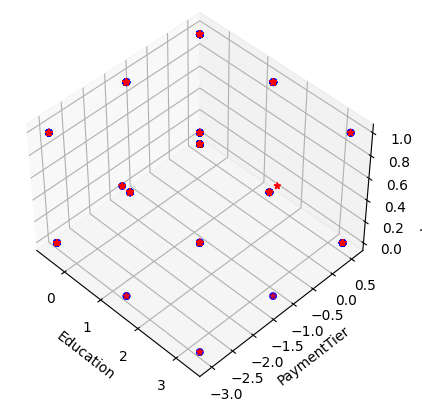

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test.T[0], X_test.T[7], Y_test, c='b', marker='o')
ax.scatter(X_test.T[0], X_test.T[7], Y_pred, c='r', marker='*')
ax.view_init(elev=45, azim=-45)
ax.set_xlabel('Education')
ax.set_ylabel('PaymentTier')
ax.set_zlabel('LeaveOrNot')
plt.show()

Gráfico 3D de educación y experiencia en el dominio actual respecto a sí abandonan o no.

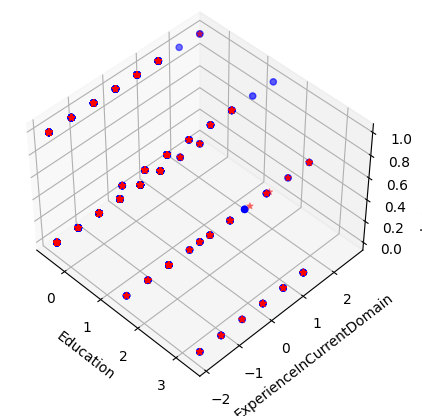

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test.T[0], X_test.T[6], Y_test, c='b', marker='o')
ax.scatter(X_test.T[0], X_test.T[6], Y_pred, c='r', marker='*')
ax.view_init(elev=45, azim=-45)
ax.set_xlabel('Education')
ax.set_ylabel('ExperienceInCurrentDomain')
ax.set_zlabel('LeaveOrNot')
plt.show()

Gráfico 3D de educación y si algunas han estado en la banca respecto a sí abandonan o no.

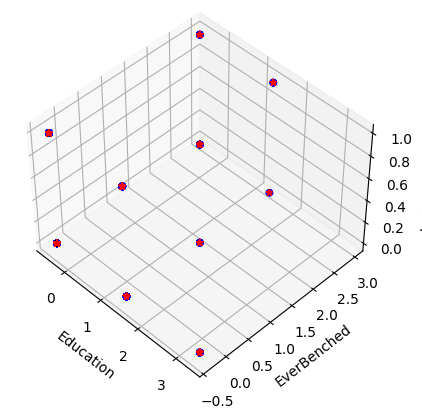

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test.T[0], X_test.T[5], Y_test, c='b', marker='o')
ax.scatter(X_test.T[0], X_test.T[5], Y_pred, c='r', marker='*')
ax.view_init(elev=45, azim=-45)
ax.set_xlabel('Education')
ax.set_ylabel('EverBenched')
ax.set_zlabel('LeaveOrNot')
plt.show()